In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle


In [8]:
data = pd.read_csv('botData.csv')
data.describe()

,count_similarity,tfidf_similarity,comment_rate,top_level_proportion,reply_time,isBot
count,1286.000000,1286.000000,1.286000e+03,1286.000000,1.286000e+03,1286.000000
mean,0.198783,0.120824,2.483005e-04,0.414488,1.029032e+04,0.143079
std,0.234944,0.177965,1.838286e-03,0.277552,4.389820e+04,0.350290
min,0.004578,0.004549,3.930000e-07,0.000000,0.000000e+00,0.000000
25%,0.076307,0.050488,1.392500e-05,0.200000,1.769125e+03,0.000000
50%,0.110902,0.063125,2.855000e-05,0.380000,6.294500e+03,0.000000
75%,0.175203,0.085941,7.160000e-05,0.600000,1.262750e+04,0.000000
max,1.000000,1.000000,4.480287e-02,1.000000,1.480904e+06,1.000000


In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.25, random_state=1)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict 

train_Y = train['isBot']
train_X = train.drop(columns = ['isBot', 'author'], axis = 1)

test_Y = test['isBot']
test_X = test.drop(columns = ['isBot', 'author'], axis = 1)

models = []
modelScores = []
modelSTD = []

In [10]:
LR_model = LogisticRegression(solver = 'lbfgs', penalty = 'l2')
LR_model.fit(train_X, train_Y)

KF = KFold(n_splits=5, random_state=1)
CV = cross_val_score(LR_model,train_X,train_Y,cv=KF, scoring='f1')
models.append('LogisticRegression')
modelScores.append(round(CV.mean(),3))
modelSTD.append(round(CV.std(),3))

C:\Users\matt\Anaconda3\envs\titanic_conda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\matt\Anaconda3\envs\titanic_conda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()


RF_grid = {"max_depth": [None],
              "max_features": [2,3,4],
              "min_samples_split": [4, 6, 8, 10, 12],
              "min_samples_leaf": [3,5,7,9,11],
              "bootstrap": [True],
              "n_estimators" :[500],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = RF_grid, cv=5, scoring='f1', n_jobs= -1, verbose = 1)

gsRFC.fit(train_X,train_Y)

RFC_best = gsRFC.best_estimator_

# Best score
print(gsRFC.best_score_)
print(gsRFC.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 75 candidates, totalling 375 fits


KeyboardInterrupt: 

Text(0.5, 1.0, 'Feature Importance')

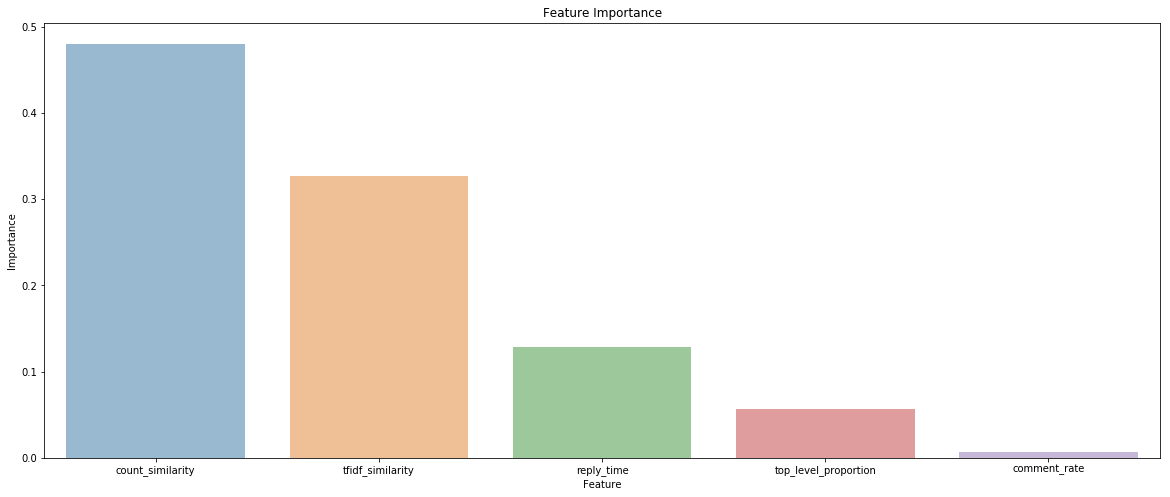

In [11]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
#Random Forest
RF_model = RandomForestClassifier(bootstrap= True, oob_score = True,
 criterion = 'gini',
 max_depth = None,
 max_features=2,
 min_samples_leaf = 3,
 min_samples_split = 6,
 n_estimators = 1000, random_state=1)

RF_model.fit(train_X, train_Y)


CV=cross_val_score(RF_model,train_X,train_Y,cv=KF, scoring='f1')
models.append('RandomForest')

modelScores.append(round(CV.mean(),3))
modelSTD.append(round(CV.std(),3))

featureImportance = pd.concat((pd.DataFrame(train_X.columns, columns = ['Feature']), 
           pd.DataFrame(RF_model.feature_importances_, columns = ['Importance'])), 
          axis = 1).sort_values(by='Importance', ascending = False)[:20]
plt.subplots(figsize=(20,8))
sns.barplot(x=featureImportance['Feature'], y=featureImportance['Importance'], alpha=.5).set_title('Feature Importance')

In [12]:
pkl_filename = "RF_model_for_bot.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(RF_model, file)

In [13]:
ModelComparison=pd.DataFrame({'CV Score':modelScores, 'Std':modelSTD}, index=models)
ModelComparison

,CV Score,Std
LogisticRegression,0.545,0.445
RandomForest,0.971,0.032


In [14]:
y_true = test_Y.reset_index().drop(columns=['index'])
true_values = y_true['isBot'].values

[[274   2]
 [  0  46]]


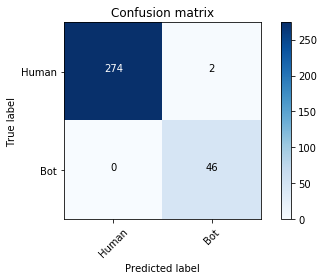

In [15]:
from sklearn.metrics import confusion_matrix
import itertools
predictions = RF_model.predict(test_X)
cnf_matrix = confusion_matrix(true_values, predictions)
np.set_printoptions(precision=2)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plt.figure()
class_names = ['Human', 'Bot']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

Two human users misclassified as a bot when they were in fact a human user. 

Text(0.5, 0, 'Bot Probability')

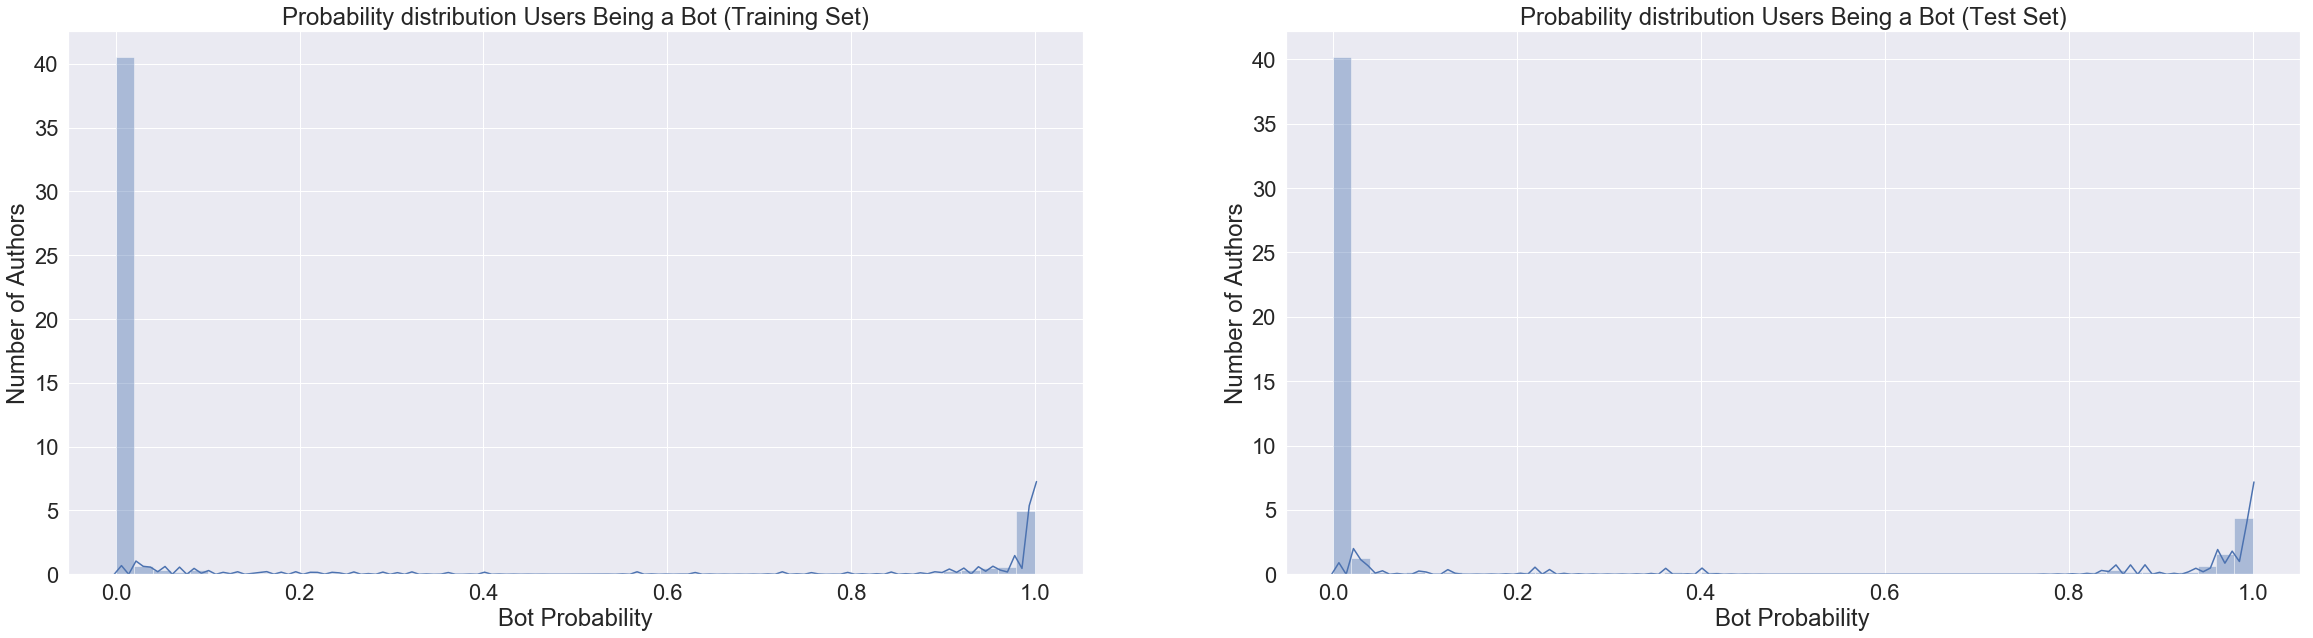

In [29]:
from sklearn.preprocessing import normalize


fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(40,10))

plt.subplot(1,2, 1)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(RF_model.predict_proba(train_X)[:, 1], norm_hist=True)
sns.set(font_scale=2)
ax.set_title('Probability distribution Users Being a Bot (Training Set)')
ax.set_ylabel('Number of Authors')
ax.set_xlabel('Bot Probability')

plt.subplot(1,2, 2)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(RF_model.predict_proba(test_X)[:, 1], norm_hist=True)
sns.set(font_scale=2)
ax.set_title('Probability distribution Users Being a Bot (Test Set)')
ax.set_ylabel('Number of Authors')
ax.set_xlabel('Bot Probability')

This is pretty informative, most authors are either given a very high probability of being a bot or a very low probability of being a bot, with very few authors in "between" these extrema.